<a href="https://colab.research.google.com/github/lisaqhou4/ML_final_project/blob/main/TCM_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 25.3 MB/s 


In [43]:
!pip install -q transformers

     |████████████████████████████████| 5.8 MB 15.9 MB/s 
     |████████████████████████████████| 7.6 MB 48.6 MB/s 
     |████████████████████████████████| 182 kB 27.3 MB/s 


In [44]:
!pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 11.3 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=c88018735f1d090c284fc5e19e64b084a9375ecdd097a5ee3e2edd84ae3c2185
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [45]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.13.0+cu116
transformers: 4.25.1



In [46]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from textwrap import wrap
import re
from emoji import demojize
import emoji

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from pylab import rcParams
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [58]:
file_path = '/content/drive/MyDrive/fine_tune_model_dict_shuffle_llr_gen_entire.bin'

In [79]:
import pandas as pd
file_path = '/content/drive/MyDrive/tcm_data/acupuncture_12_15.xlsx'
df_ap = pd.read_excel(file_path)

file_path = '/content/drive/MyDrive/tcm_data/herbal_medicine_12_15.xlsx'
df_hm = pd.read_excel(file_path)

file_path = '/content/drive/MyDrive/tcm_data/integrative_medicine_12_15.xlsx'
df_im = pd.read_excel(file_path)

file_path = '/content/drive/MyDrive/tcm_data/qigong_12_15.xlsx'
df_qg = pd.read_excel(file_path)

file_path = '/content/drive/MyDrive/tcm_data/tcm_12_15.xlsx'
df_tcm = pd.read_excel(file_path)

df = pd.concat([df_ap, df_hm, df_im, df_qg, df_tcm], axis=0)

In [29]:
df.head(3)

,Tweet Id,Text,Name,Screen Name,UTC,Created At,Favorites,Retweets,Language,Client,Tweet Type,URLs,Hashtags,Mentions,Media Type,Media URLs,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,1603475957704032256,Acupuncture for Dogs and Cats (A Pocket Atlas)...,Carleton67gHsI,carleton67g,2022-12-15T19:43:54.000Z,Thu Dec 15 19:43:54 +0000 2022,0,0,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Tweet,https://www.amazon.com/dp/3131546913?tag=lance...,0,0,photo,https://pbs.twimg.com/media/FkCw4L7UoAALNOM.jpg,NaN,NaN,NaN
1,1603474920897450028,RT @mane3sha : things that will end up making ...,It is well with us,kedem2134,2022-12-15T19:39:46.000Z,Thu Dec 15 19:39:46 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/android"" ...",Retweet,NaN,0,0,NaN,NaN,NaN,NaN,NaN
2,1603474658422099978,RT @mane3sha : things that will end up making ...,/Rah•kem/(ism),OldmanRakim,2022-12-15T19:38:44.000Z,Thu Dec 15 19:38:44 +0000 2022,0,0,en,"<a href=""http://twitter.com/download/iphone"" r...",Retweet,NaN,0,0,NaN,NaN,NaN,NaN,NaN


In [80]:
df = df.drop(['Tweet Id', 'UTC', 'Retweets', 'Name', 'Screen Name' , 'Favorites', 'Client', 'Hashtags', 'Mentions', 'Media URLs', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18' ], axis=1)

In [81]:
df.head(3)

,Text,Created At,Language,Tweet Type,URLs,Media Type
0,Acupuncture for Dogs and Cats (A Pocket Atlas)...,Thu Dec 15 19:43:54 +0000 2022,en,Tweet,https://www.amazon.com/dp/3131546913?tag=lance...,photo
1,RT @mane3sha : things that will end up making ...,Thu Dec 15 19:39:46 +0000 2022,en,Retweet,NaN,NaN
2,RT @mane3sha : things that will end up making ...,Thu Dec 15 19:38:44 +0000 2022,en,Retweet,NaN,NaN


In [84]:
df = df[df['Language']=='en']
df = df[df['Tweet Type']!='Retweet']
df = df.drop(['Created At', 'Language', 'URLs'], axis=1)
df.set_index(['Age'], inplace = True)

In [86]:
df.shape

(2881, 6)

In [88]:
import emoji 

def clean1(tweet):
  txt = re.sub(r"https?://\S+", "", tweet) # remove hyperlink
  txt = demojize(txt)                      # translate emoji
  txt = re.sub("_", " ", txt)
  txt = re.sub("\n", " ", txt)
  txt = re.sub(":", " ", txt)
  txt = re.sub(r'@[A-Za-z0-9_]+', '', txt) # remove mention
  txt = re.sub(r'#[A-Za-z]+[A-Za-z0-9-_]+', '', txt)
  return txt

def clean2(tweet):
  txt = re.sub(r"https?://\S+", "", tweet) #remove hyperlink
  txt = re.sub("\n", " ", txt)
  txt = re.sub(":", " ", txt)
  txt = re.sub(r"&amp", " ", txt)
  txt = re.sub(r'@[A-Za-z0-9_]+[A-Za-z0-9-_]+', '', txt) #remove mention
  txt = re.sub(r'#[A-Za-z]+[A-Za-z0-9-_]+', '', txt)
  txt = re.sub("_", " ", txt)
  txt = emoji.replace_emoji(txt, replace='')
  return txt

df.Text = df.Text.apply(clean2)

df.head(2)

,Text,Tweet Type,Media Type
0,Acupuncture for Dogs and Cats (A Pocket Atlas)...,Tweet,photo
12,Doing well. It's been a week of self-care. (H...,Reply,NaN


In [89]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

token_lens = []

for txt in df.Text:
  tokens = tokenizer.encode(txt, max_length=1000)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


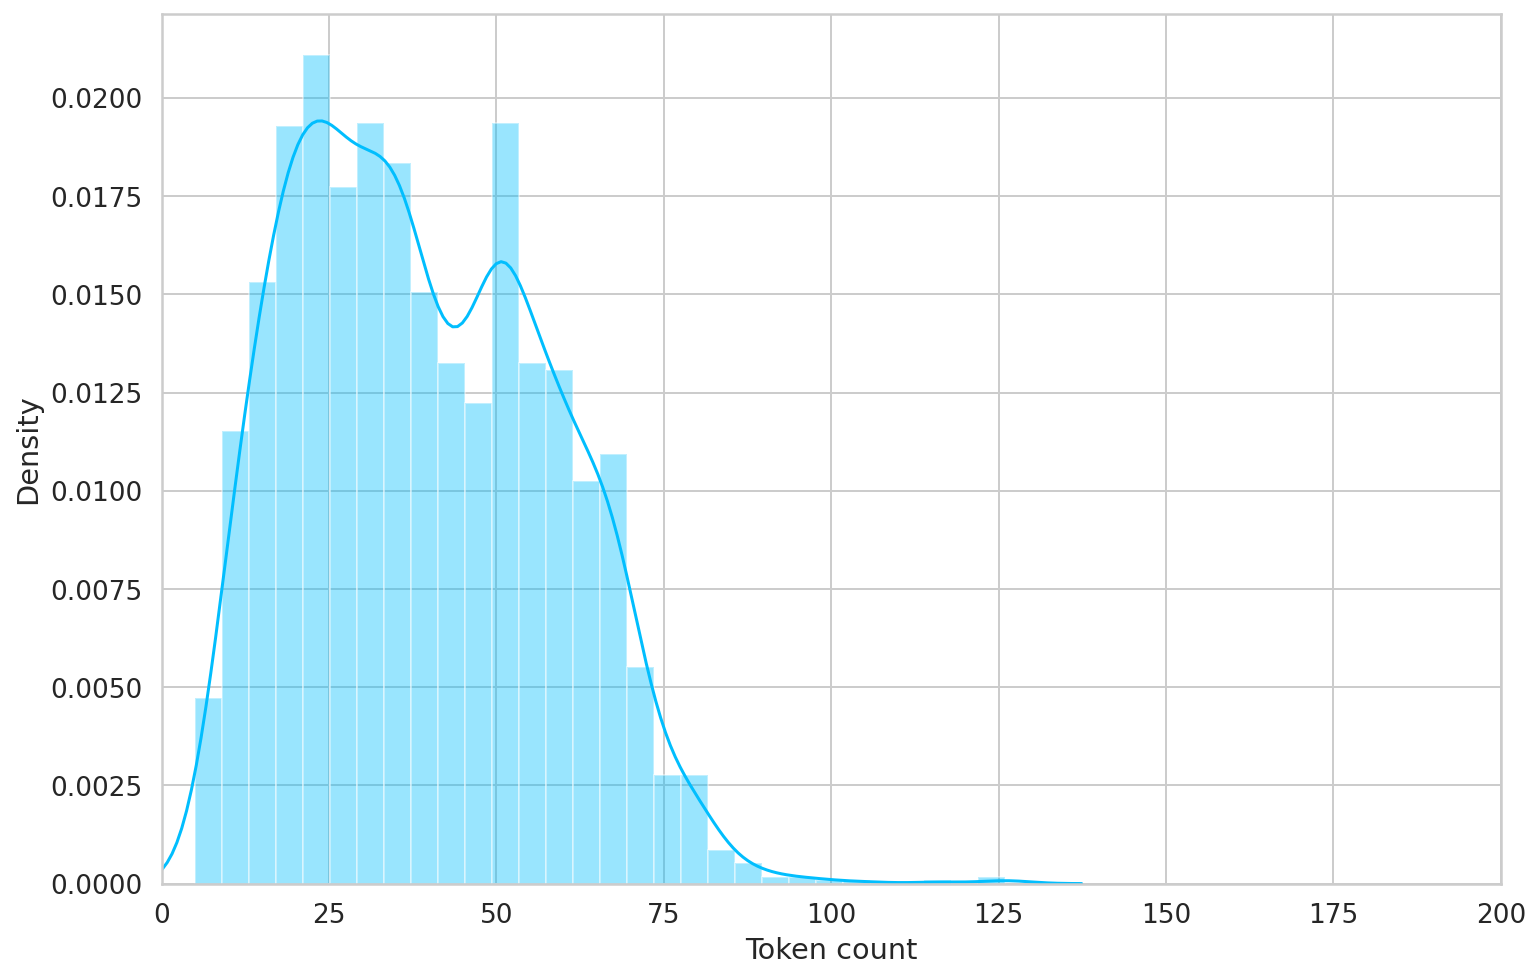

In [90]:
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

In [91]:
from transformers import BertConfig, BertModel
import torch.nn as nn
from torch.optim import AdamW

In [65]:
PRE_TRAINED_MODEL_NAME = 'bert-large-cased'   # 'bert-base-cased'

#This is the dict of trained model name
#PRE_TRAINED_DICT_NAME = 'checkpoints/' + PRE_TRAINED_MODEL_NAME + '/pretrain_model_dict.bin'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [66]:
MAX_LEN = 160
NUM_SENTIMENT = 3

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    ).to_tuple()
    output = self.drop(pooled_output)
    return self.out(output)

model = SentimentClassifier(NUM_SENTIMENT)
model.load_state_dict(torch.load('/content/drive/MyDrive/fine_tune_model_dict_shuffle_llr_gen_entire.bin',  map_location=torch.device('cpu')))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [131]:
def predict(text):

  encoded_review = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)


  return prediction.numpy()[0]

In [124]:
class_names = ['positive', 'neutral', 'negative']

In [151]:
for i in range(len(df.Text)):
  if(df['Label'][i] == ''):
    if(i%20==0): 
      print(i)
    df['Label'][i] = predict(df.Text[i])

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880


In [152]:
df.head(10)

,Text,Tweet Type,Media Type,Label
0,Acupuncture for Dogs and Cats (A Pocket Atlas)...,Tweet,photo,0
1,Doing well. It's been a week of self-care. (H...,Reply,NaN,0
2,This woman I work with is the reason why I can...,Tweet,NaN,2
3,Acupuncture in the Treatment of Children (3rd ...,Tweet,photo,1
4,I’ve never tried acupuncture does it work,Reply,NaN,0
5,treatments are more effective when you have t...,Tweet,NaN,0
6,Everyday acupuncture feels like too much,Reply,NaN,2
7,“Why Do I Have To Get Treatment So Often?”,Tweet,NaN,1
8,Mariah Carey Credits Daily With Helping Her G...,Tweet,NaN,0
9,Planning my favorite kind of Friday night tomo...,Tweet,NaN,1


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Count')

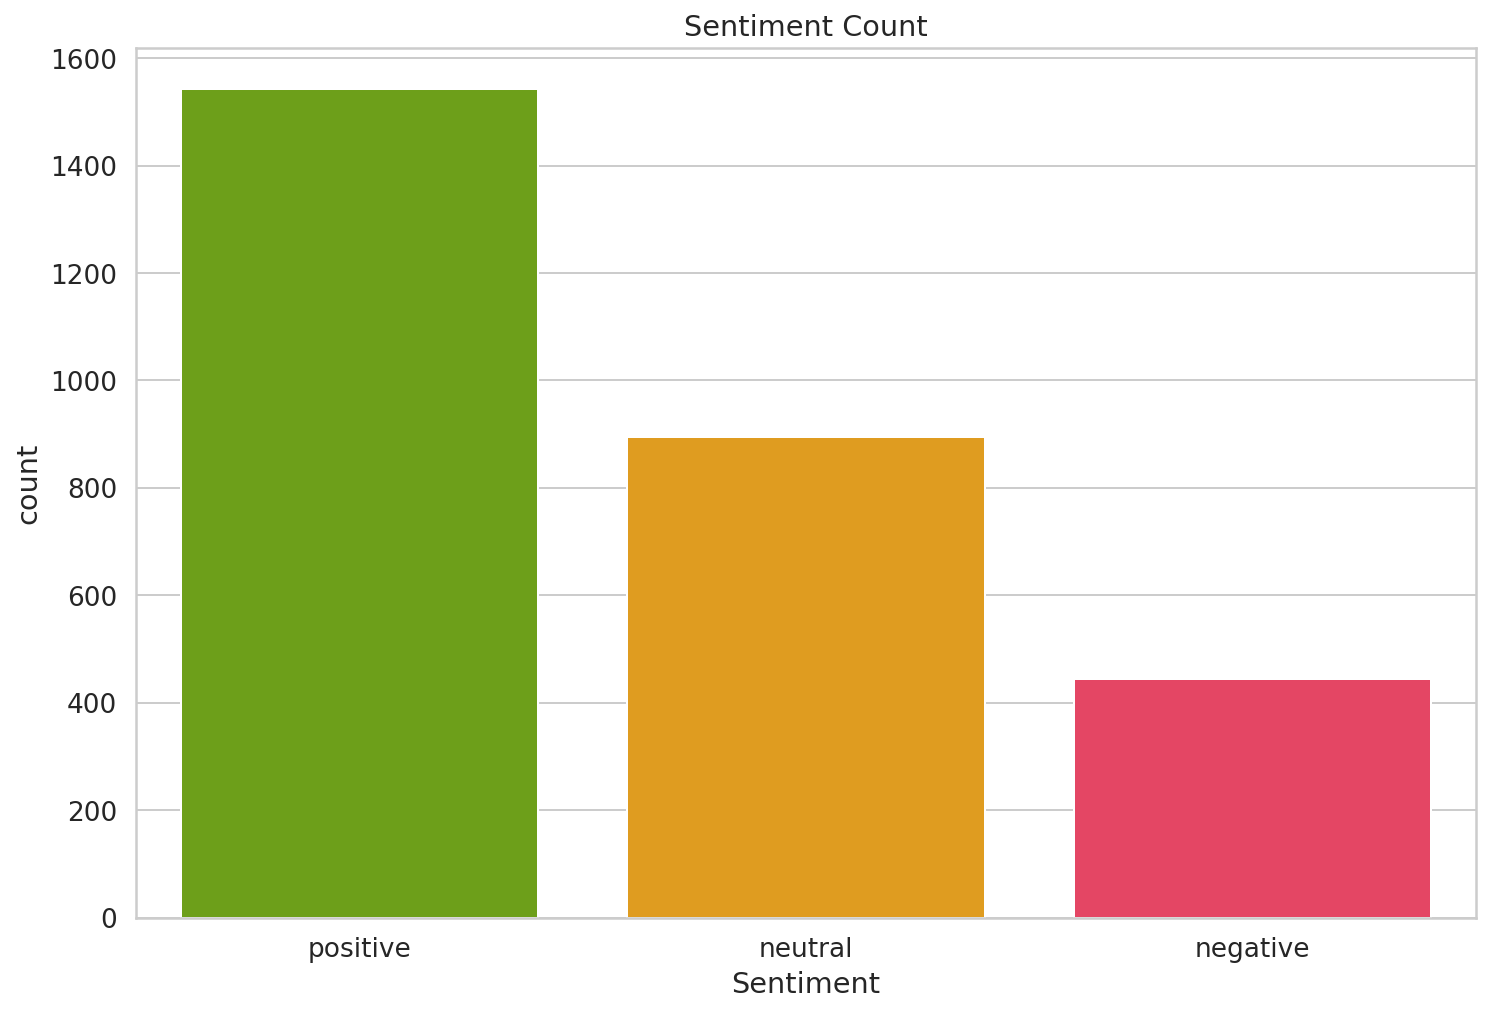

In [153]:
sns.countplot(df.Label,  palette=['#73b504',"#ffa500", '#Fe2c54'])
plt.xticks([0, 1, 2],['positive','neutral','negative'])
plt.xlabel('Sentiment');
plt.title("Sentiment Count")

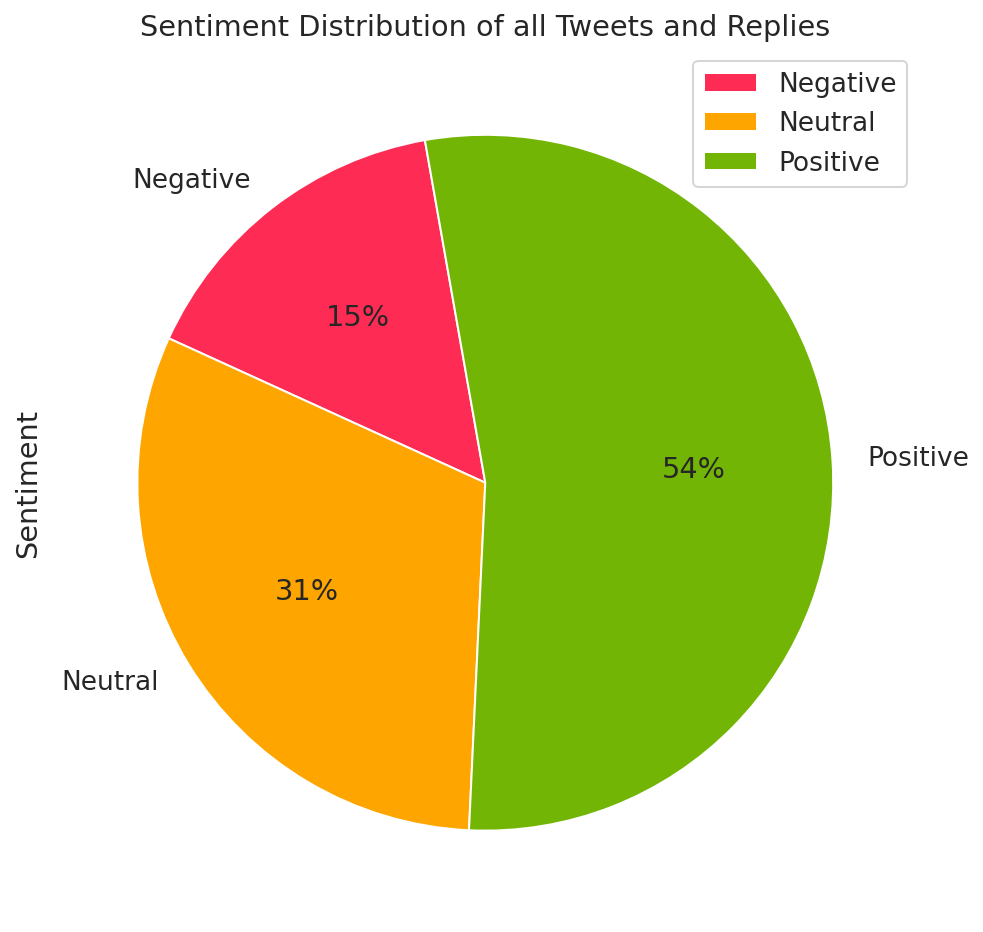

In [194]:
# Defining colors for the pie chart
val = df['Label'].value_counts()
df_all = pd.DataFrame({'Sentiment': ['Positive', 'Neutral', 'Negative'],
                          'count': [val[0], val[1], val[2]]})
colors = ['#Fe2c54', "#ffa500", '#73b504']
df_all.groupby(['Sentiment']).sum().plot(kind='pie', subplots=True, figsize=(16,8), autopct='%1.0f%%', colors=colors, startangle=100)
plt.ylabel('Sentiment');
plt.title("Sentiment Distribution of all Tweets and Replies");

In [154]:
df_tweet = df[df['Tweet Type']=='Tweet']

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Count')

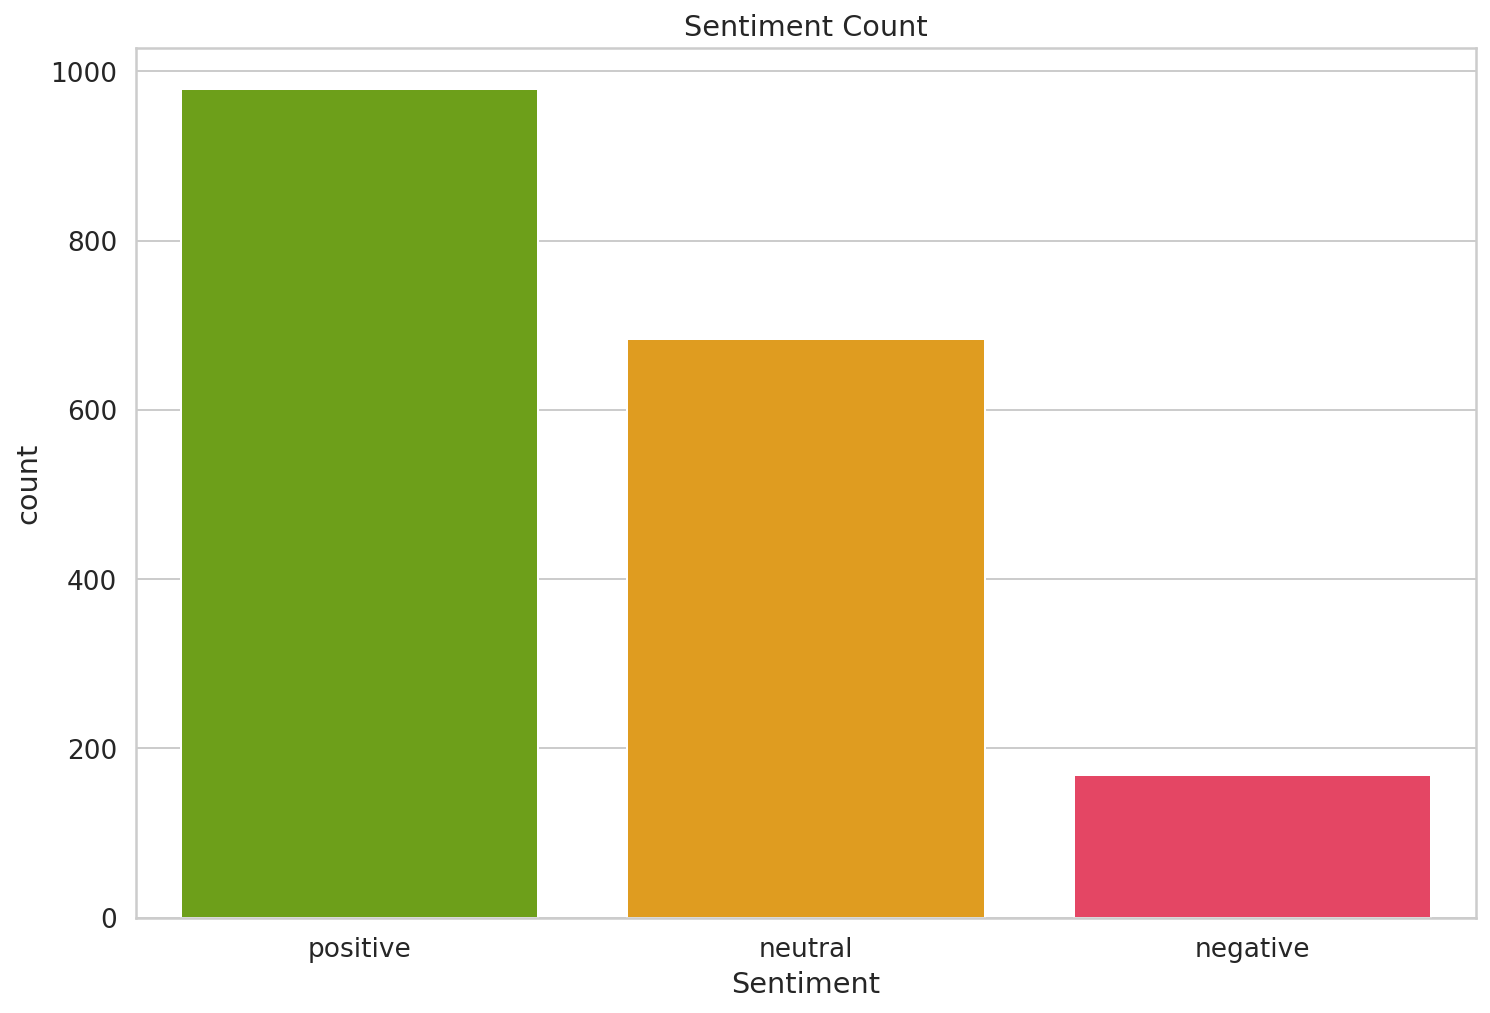

In [155]:
sns.countplot(df_tweet.Label,  palette=['#73b504',"#ffa500", '#Fe2c54'])
plt.xticks([0, 1, 2],['positive','neutral','negative'])
plt.xlabel('Sentiment');
plt.title("Sentiment Count")

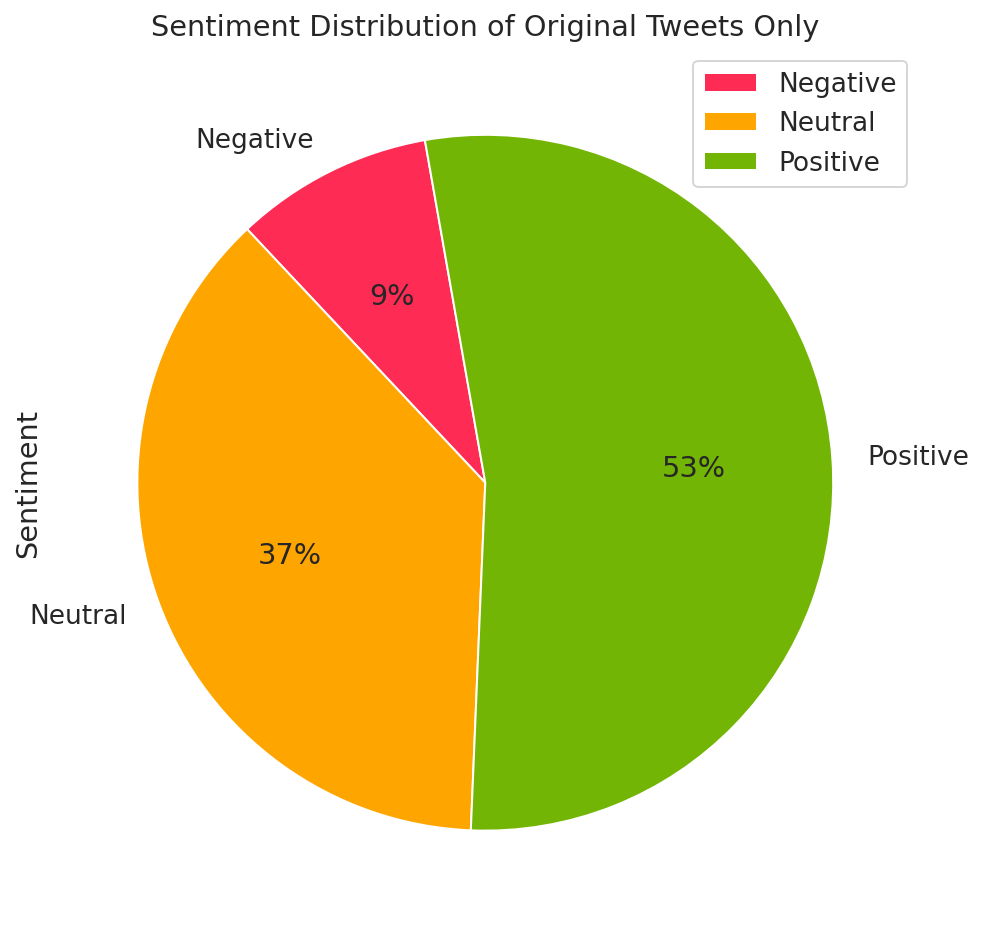

In [196]:
val = df_tweet['Label'].value_counts()
df_all = pd.DataFrame({'Sentiment': ['Positive', 'Neutral', 'Negative'],
                          'count': [val[0], val[1], val[2]]})
colors = ['#Fe2c54', "#ffa500", '#73b504']
df_all.groupby(['Sentiment']).sum().plot(kind='pie', subplots=True, figsize=(16,8), autopct='%1.0f%%', colors=colors, startangle=100)
plt.ylabel('Sentiment');
plt.title("Sentiment Distribution of Original Tweets Only");

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Count')

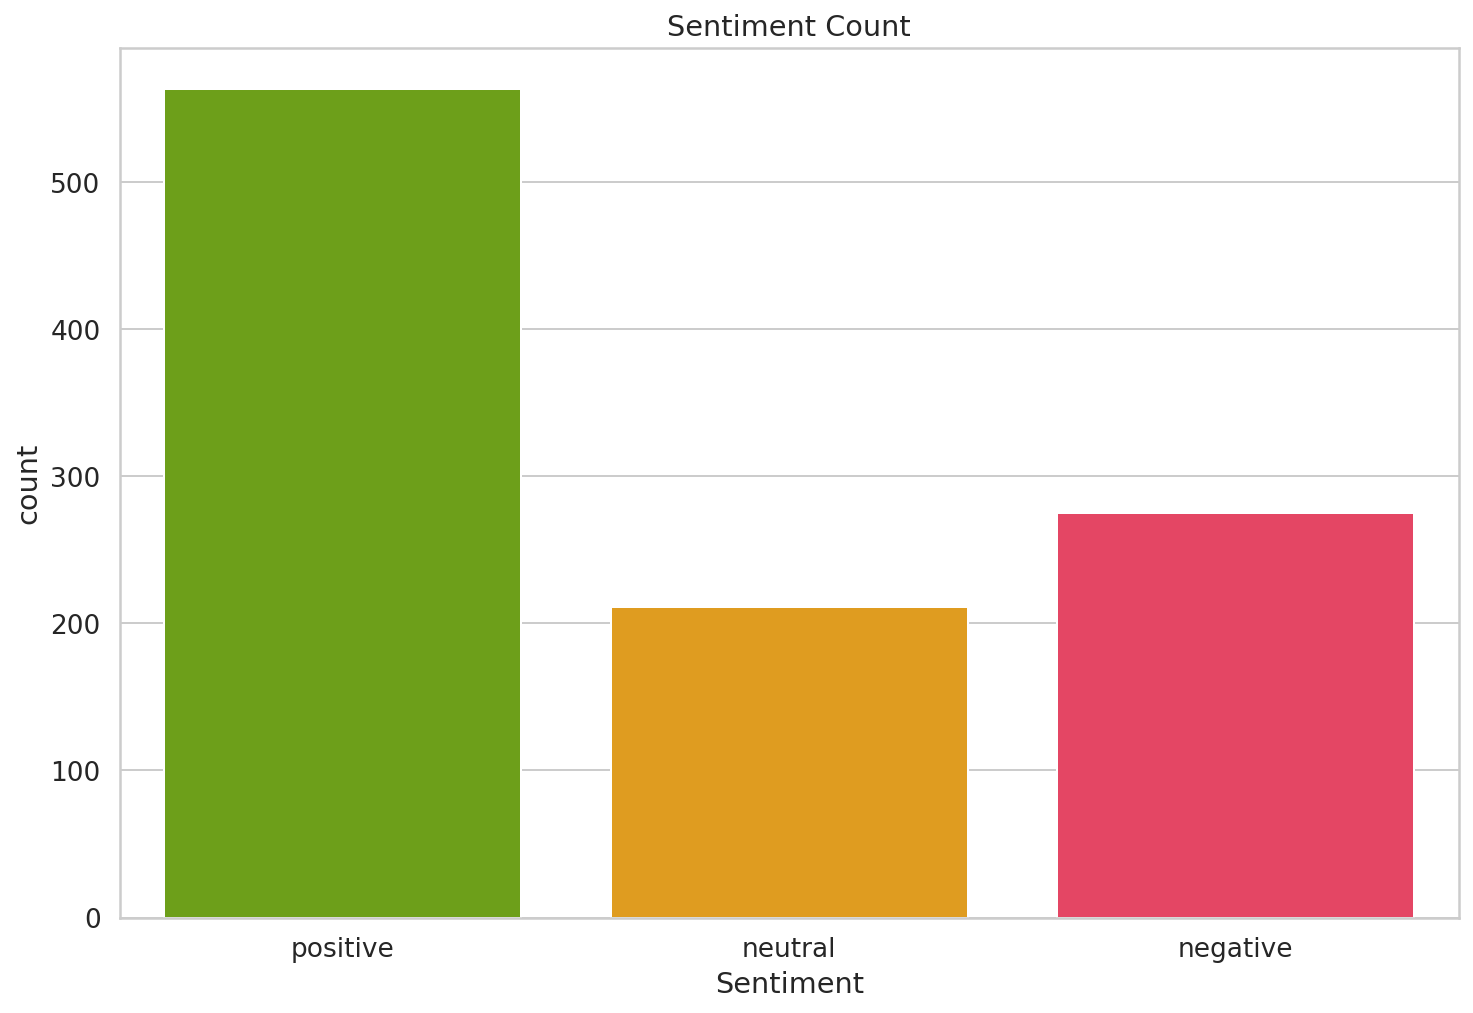

In [156]:
df_reply = df[df['Tweet Type']=='Reply']
sns.countplot(df_reply.Label,  palette=['#73b504',"#ffa500", '#Fe2c54'])
plt.xticks([0, 1, 2],['positive','neutral','negative'])
plt.xlabel('Sentiment');
plt.title("Sentiment Count")

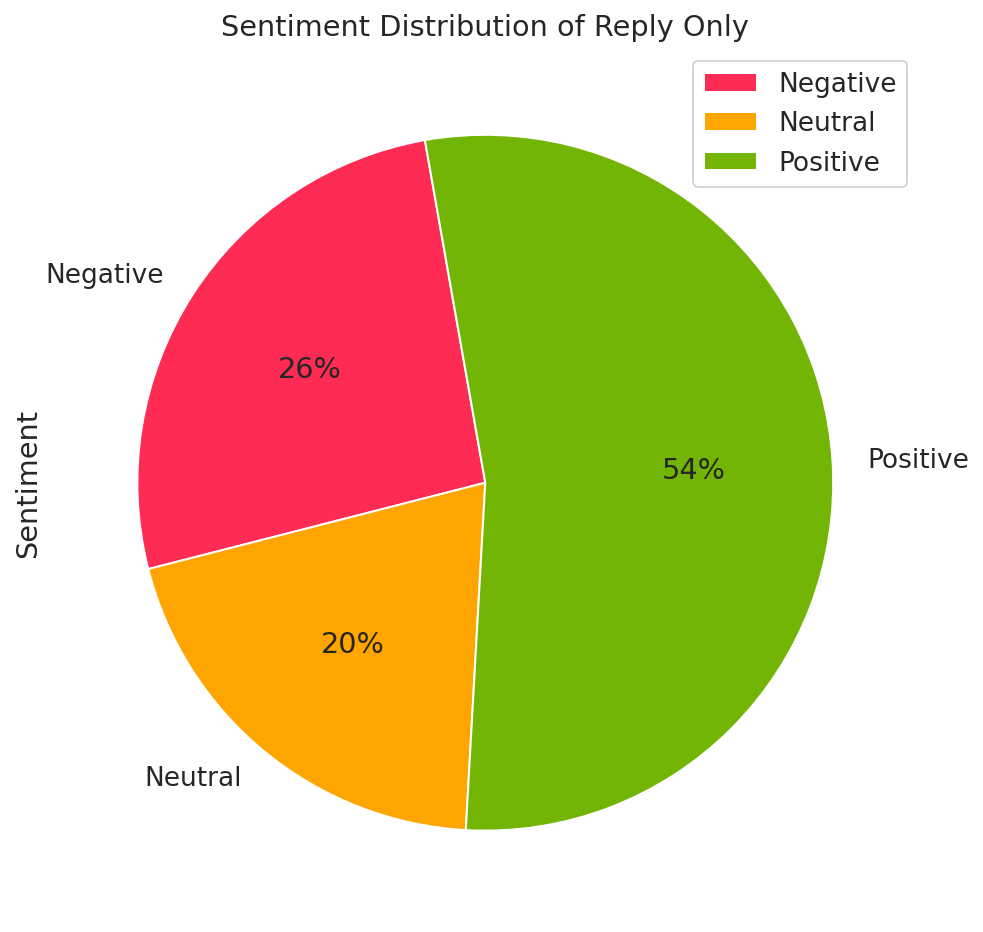

In [197]:
val = df_reply['Label'].value_counts()
df_all = pd.DataFrame({'Sentiment': ['Positive', 'Neutral', 'Negative'],
                          'count': [val[0], val[1], val[2]]})
colors = ['#Fe2c54', "#ffa500", '#73b504']
df_all.groupby(['Sentiment']).sum().plot(kind='pie', subplots=True, figsize=(16,8), autopct='%1.0f%%', colors=colors, startangle=100)
plt.ylabel('Sentiment');
plt.title("Sentiment Distribution of Reply Only");